# Mission 2.2

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.

### 🚀 Your Tools
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts (~30 days * 50 submissions = 1500 total attempts per student).

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import scipy.optimize
from typing import Any
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import Birch, DBSCAN
import umap.umap_ as umap

import torch
from torchvision import models, transforms


from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA

In [166]:
data = pd.read_csv('unsupervised_original.csv')
data = data.reindex(sorted(data.columns, key=lambda x: int(x.split('_')[1])), axis=1)

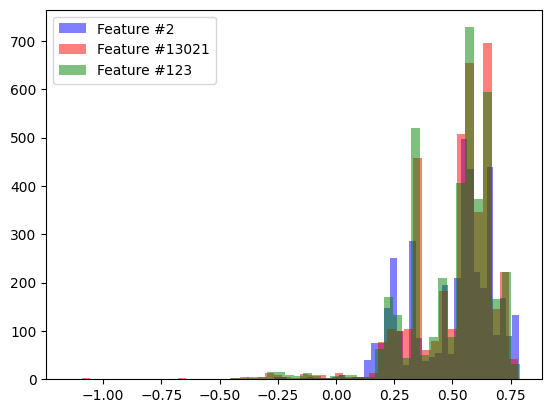

In [8]:
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.hist(data.iloc[:, 123], bins=50, color='green', alpha=0.5, label='Feature #123')
plt.legend()

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

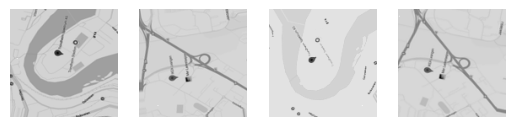

In [108]:
# Assuming 'data' is a pandas DataFrame without the 'ID' column
image_data = data.values.reshape(-1, 128, 128)

# Visualize a few sample images
num_samples = 4
for i in range(num_samples):  # Adjust the range as needed
    plt.subplot(1, num_samples, i+1)
    # plt.imsave(f'pics/image{i}.png', image_data[i])
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')
plt.show()

In [30]:

# Define a transformation to match the input requirements of the CNN
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # For grayscale images
])

# Load pre-trained model (e.g., ResNet)
model = models.resnet18(pretrained=True)
model.eval()

# Modify the first convolution layer to accept single-channel images
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Function to extract features
def extract_features(images):
    features = []
    with torch.no_grad():
        for img in images:
            img = (img * 255).astype('uint8')  # Ensure image is in correct format
            img_transformed = transform(img)
            img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension
            feature = model(img_transformed)
            features.append(feature.numpy().flatten())
    return np.array(features)

image_features = extract_features(image_data)

/home/christian/.pyenv/versions/3.12.7/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/christian/.pyenv/versions/3.12.7/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [126]:
processed_data = image_features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

In [132]:
# pca = PCA(n_components=20)  # Adjust as needed
# pca_features = pca.fit_transform(scaled_data)

umap_reducer = umap.UMAP(n_components=200, min_dist = 0, random_state=42) # Shape (4000, 10)
reduced_data: np.ndarray = umap_reducer.fit_transform(scaled_data) # type: ignore

/home/christian/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [133]:
# reduced_data = reduced_data[:, :2]
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data[:, :2])

birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(reduced_data)

In [134]:
submission_labels: np.ndarray = kmeans_labels
name = "Herbert_DildoTryneV9"

def create_submission():
    """Create a csv-file called submission.csv in current folder. Tow columns: [ID, cluster], both being ints."""
    submission_df = pd.DataFrame({'ID': data.index, 'cluster': submission_labels})
    submission_df.to_csv(f'csv-files/{name}.csv', index=False)

create_submission()

for i in range(4):
    print(f"Cluster {i}: {np.sum(submission_labels == i)} occurrences")

print('\nBirch:')
for i in range(4):
    print(f"Cluster {i}: {np.sum(birch_labels == i)} occurrences")

Cluster 0: 1080 occurrences
Cluster 1: 949 occurrences
Cluster 2: 971 occurrences
Cluster 3: 1000 occurrences

Birch:
Cluster 0: 949 occurrences
Cluster 1: 1000 occurrences
Cluster 2: 971 occurrences
Cluster 3: 1080 occurrences


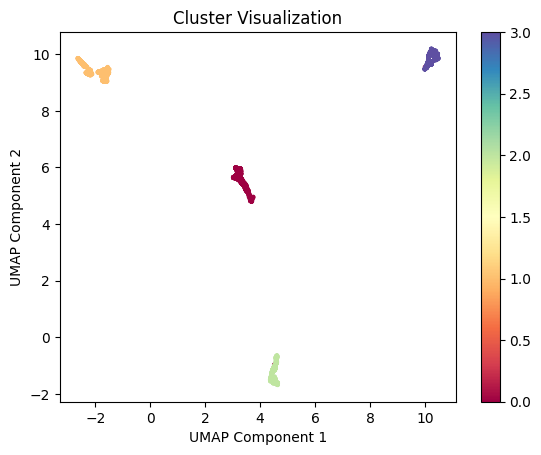

In [76]:
import matplotlib.pyplot as plt

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=submission_labels, cmap='Spectral', s=5)
plt.title('Cluster Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar()
plt.show()


## Create submission using the calculated cluster labels

In [142]:
# from skimage.feature import hog

# hog_features = []
# for img in image_data:
#     feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
#     hog_features.append(feature)
# hog_features = np.array(hog_features)

In [172]:
# my_data = data.values
# my_data = hog_features



scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [144]:
# Worse methods: TSNE, ISOMAP, DBSCAN, ISOLATION FOREST, KMEANS
# pca = PCA(n_components=20) # Last Best : 20 [98%], 18 [97.75%], 16 [97.8%] 
# pca_data = pca.fit_transform(scaled_data)

In [173]:

# 10 and 11 are approx equall powerful. 10 -> 0.98, 11 -> 9.97950 9 -> 71.8

# n_neighbors
# n_neighbors = 10
# n_components = 2
# dist = 0
pca_data = scaled_data
umap_reducer = umap.UMAP(n_components=2, n_neighbors = 10, min_dist = 0, random_state=42) # Shape (4000, 10)
# umap_reducer = umap.UMAP(n_components=16, min_dist = 0, random_state=42) # Shape (4000, 10)
reduced_data: np.ndarray = umap_reducer.fit_transform(pca_data) # type: ignore

# tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)  # n_components=2 for 2D output
# tsne_data = tsne.fit_transform(pca_data)


/home/christian/.pyenv/versions/3.12.7/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [174]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_data)

# birch = Birch(n_clusters=n_clusters)
# cluster_labels = birch.fit_predict(reduced_data)

In [175]:
# submission_labels: np.ndarray = cluster_labels
submission_labels: np.ndarray = kmeans_labels
name = "Herbert_DildoTryneV10"

def create_submission():
    """Create a csv-file called submission.csv in current folder. Tow columns: [ID, cluster], both being ints."""
    submission_df = pd.DataFrame({'ID': data.index, 'cluster': submission_labels})
    submission_df.to_csv(f'csv-files/{name}.csv', index=False)

create_submission()

for i in range(n_clusters):
    print(f"Cluster {i}: {np.sum(submission_labels == i)} occurrences")

print('\nkmeans:')
for i in range(n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans_labels == i)} occurrences")

Cluster 0: 1026 occurrences
Cluster 1: 939 occurrences
Cluster 2: 903 occurrences
Cluster 3: 1132 occurrences

kmeans:
Cluster 0: 1026 occurrences
Cluster 1: 939 occurrences
Cluster 2: 903 occurrences
Cluster 3: 1132 occurrences


In [165]:
data = pd.read_csv('csv-files/Herbert_DildoTryneV10.csv')
clusts = data.values[:,1]

for i in range(4):
    print(f"Cluster {i}: {np.sum(clusts == i)} occurrences")

for i, val in enumerate(clusts == 3):
    if val:
        print(i)

Cluster 0: 997 occurrences
Cluster 1: 1000 occurrences
Cluster 2: 999 occurrences
Cluster 3: 1004 occurrences
4
24
28
30
33
34
38
40
56
62
64
80
88
89
91
101
102
104
121
123
125
130
132
133
135
140
146
148
151
153
158
159
162
163
167
174
176
178
180
187
190
197
200
204
212
213
216
217
221
222
225
228
233
242
248
254
256
263
265
269
273
274
279
280
283
287
290
297
305
307
311
321
326
328
333
335
339
340
343
344
345
348
349
359
361
364
367
372
375
378
383
392
393
394
395
400
407
408
418
420
423
431
432
433
441
452
455
458
465
467
471
477
495
498
505
507
513
516
520
524
525
526
528
532
533
538
549
550
555
558
568
569
571
580
581
586
587
597
602
607
609
610
611
615
616
620
621
632
639
641
642
646
647
648
654
655
660
661
664
666
668
669
676
680
681
683
687
696
704
705
709
717
718
721
727
729
732
736
744
745
746
748
749
751
753
760
763
766
767
772
782
786
793
799
802
808
819
823
825
830
833
836
839
843
855
863
870
871
872
877
879
884
890
891
902
905
912
921
931
932
934
935
939
940
948
953
95